### TTV analysis assuming i.i.d. Gaussian noise w/ manual initializion of inverse mass matrix

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
from jax import config, random
import numpyro, jax
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_value
config.update('jax_enable_x64', True)
numpyro.set_platform('cpu')
num_chains = 1
numpyro.set_host_device_count(num_chains)
print ('# jax device count:', jax.local_device_count())

# jax device count: 1


In [2]:
from jnkepler.jaxttv import JaxTTV
from jnkepler.jaxttv.infer import ttv_default_parameter_bounds, ttv_optim_curve_fit, scale_pdic
import corner

In [3]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
plt.rcParams["figure.figsize"] = (12,6)
from matplotlib import rc
rc('text', usetex=False)

### define tcobs, errorobs, p_init
- lists of length = (# of planets)
- elements of tcobs and errorobs: arrays of transit times and errors for each planet
- elements of p_init: (reasonably) good guesses for planets' mean periods

In [4]:
d = pd.read_csv("kep51/ttv.txt", sep="\s+", header=None, names=['tnum', 'tc', 'tcerr', 'dnum', 'planum'])
tcobs = [jnp.array(d.tc[d.planum==j+1]) for j in range(3)]
errorobs = [jnp.array(d.tcerr[d.planum==j+1]) for j in range(3)]
p_init = [45.155305, 85.31646, 130.17809] # rough initial guess
dt = 1.0
t_start, t_end = 155., 2950.
jttv = JaxTTV(t_start, t_end, dt, tcobs, p_init, errorobs=errorobs, print_info=True)

# number of transiting planets:    3
# integration starts at:           155.00
# first transit time in data:      159.11
# last transit time in data:       2945.75
# integration ends at:             2950.00
# integration time step:           1.0000 (1/45 of innermost period)



### optimization

In [5]:
param_bounds = ttv_default_parameter_bounds(jttv)

/Users/k_masuda/miniforge3/envs/jax4/lib/python3.10/site-packages/jnkepler-0.1.0-py3.10.egg/jnkepler/jaxttv/infer.py:97: UserWarning: Bounds for cosi/lnode not provided: assuming coplanar orbits.
  warnings.warn(


# running least squares optimization...
# objective function: 41552.23 --> 47.72 (53 data)
# elapsed time: 2.2 sec


/Users/k_masuda/miniforge3/envs/jax4/lib/python3.10/site-packages/jnkepler-0.1.0-py3.10.egg/jnkepler/jaxttv/jaxttv.py:508: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


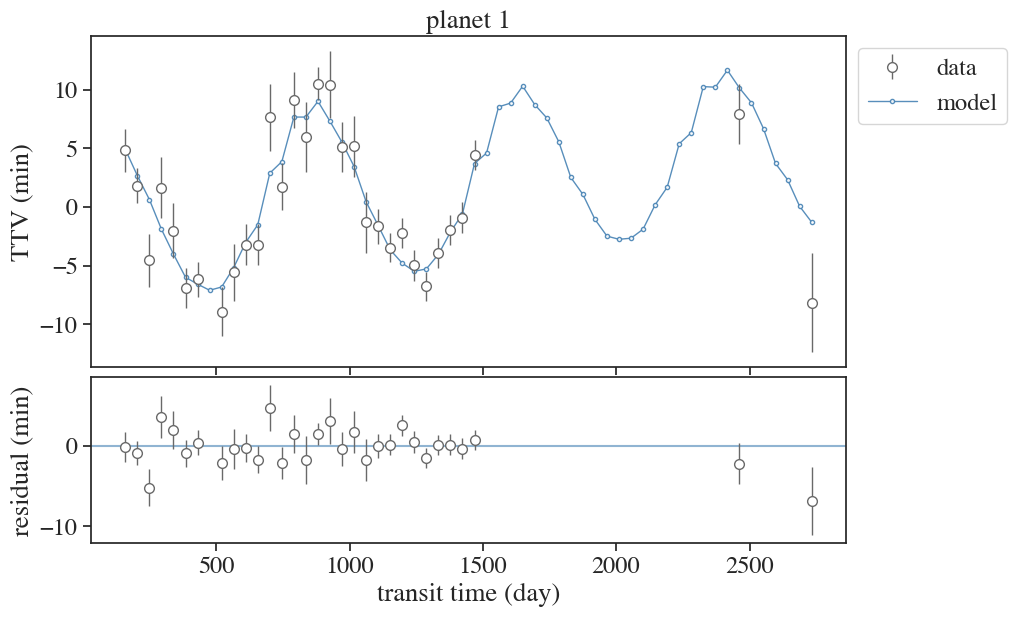

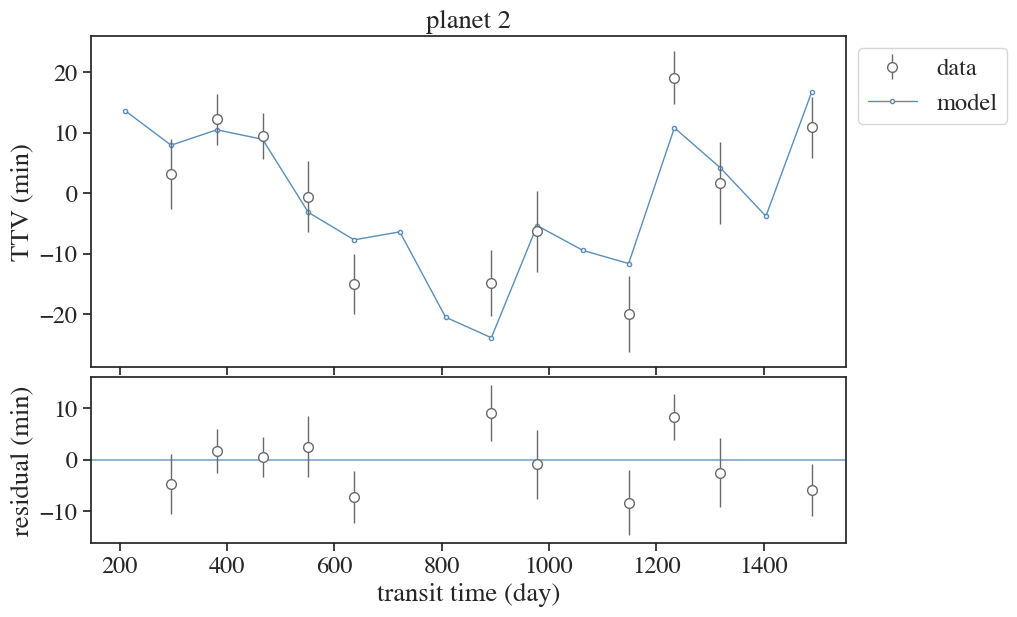

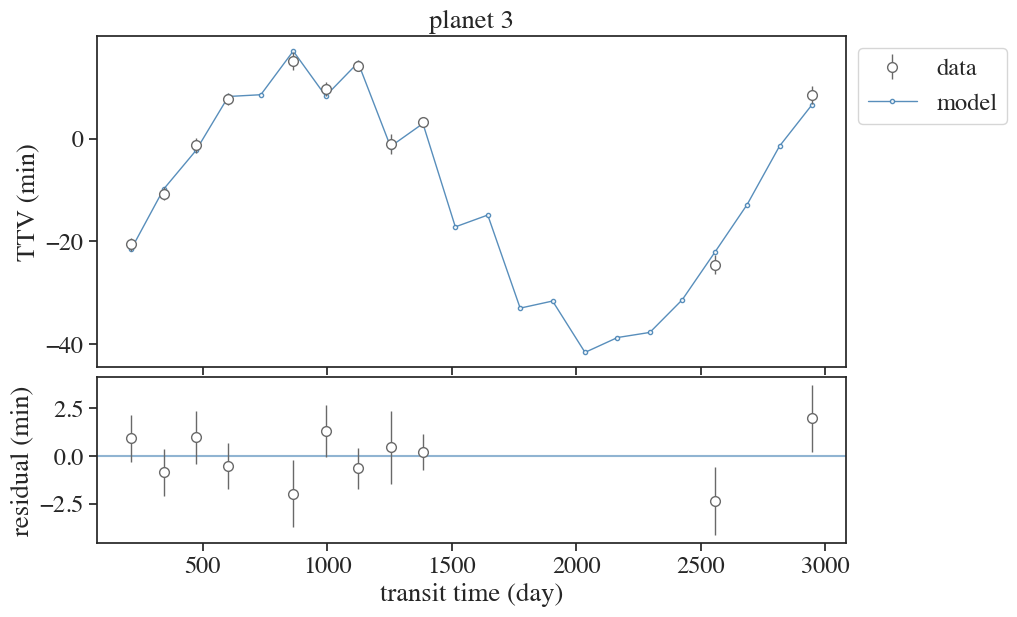

In [6]:
popt = ttv_optim_curve_fit(jttv, param_bounds)

In [7]:
popt

{'period': array([ 45.15410981,  85.31450211, 130.18413883]),
 'ecosw': array([-0.01716578,  0.01900848,  0.01176759]),
 'esinw': array([-0.04111577, -0.03567318, -0.02880392]),
 'tic': array([159.11025927, 295.3210035 , 212.02343262]),
 'lnpmass': array([-11.52119756, -11.31174132, -11.04803682]),
 'pmass': Array([9.91762027e-06, 1.22284994e-05, 1.59183692e-05], dtype=float64)}

### check precision & residual distribution

In [8]:
tc, _ = jttv.check_timing_precision(popt)

# fractional energy error (symplectic, dt=1.00e+00): 3.40e-09
# fractional energy error (symplectic, dt=4.52e-02): 7.09e-12
# max difference in tc: 6.09e-06 days (0.53 sec)


sample: 100%|██████████| 1000/1000 [00:00<00:00, 1007.05it/s, 3 steps of size 4.65e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      lndf      3.30      0.86      3.33      2.08      4.60    159.63      1.00
     lnvar     -0.18      0.23     -0.19     -0.51      0.27    171.32      1.00

Number of divergences: 0


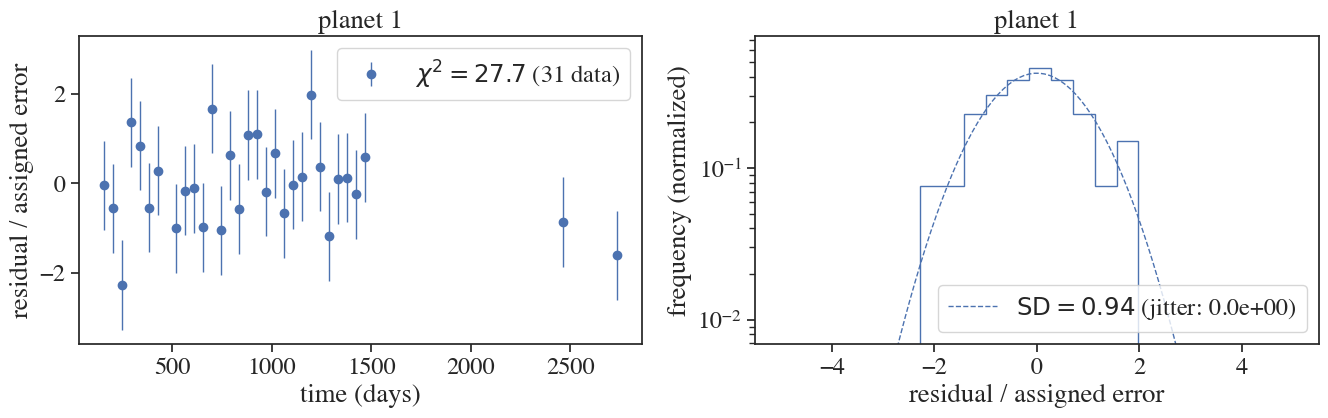

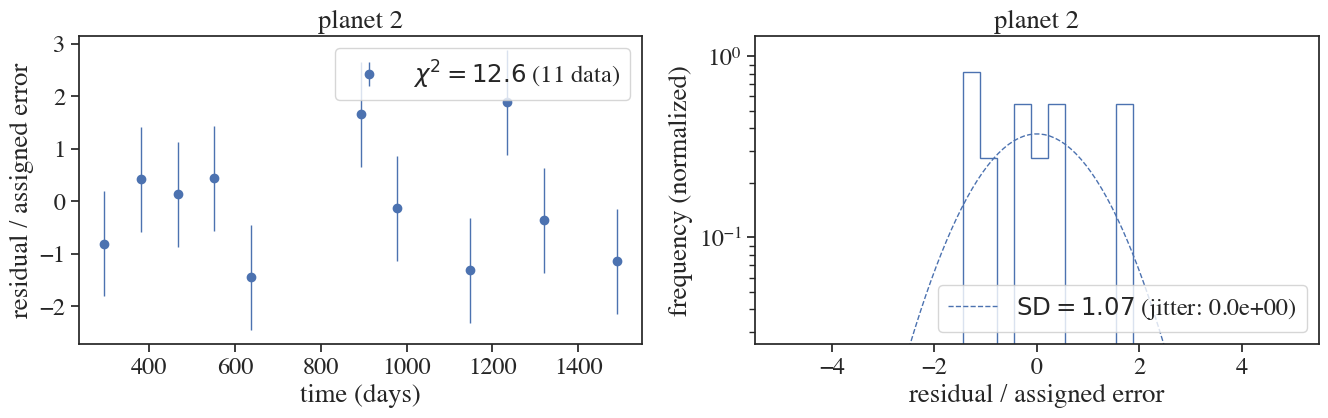

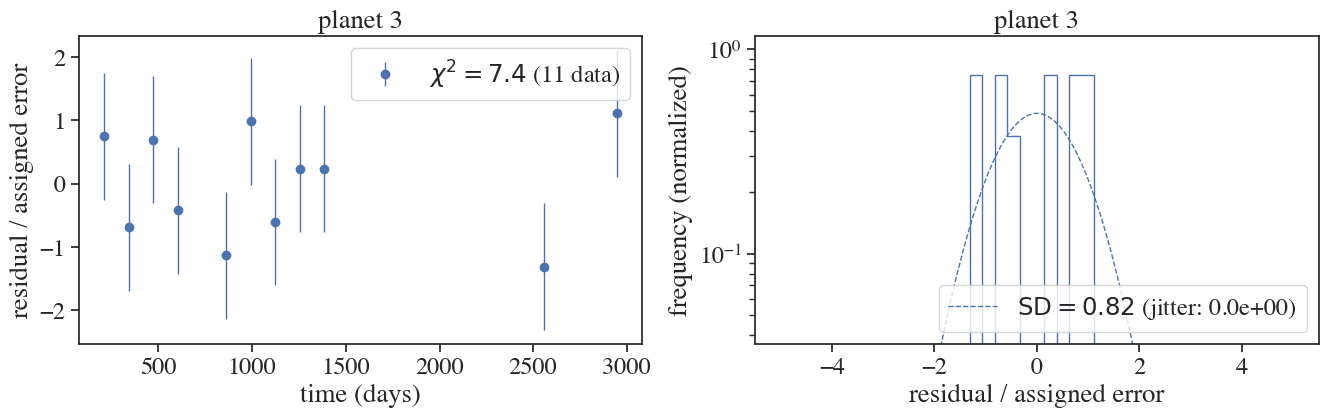

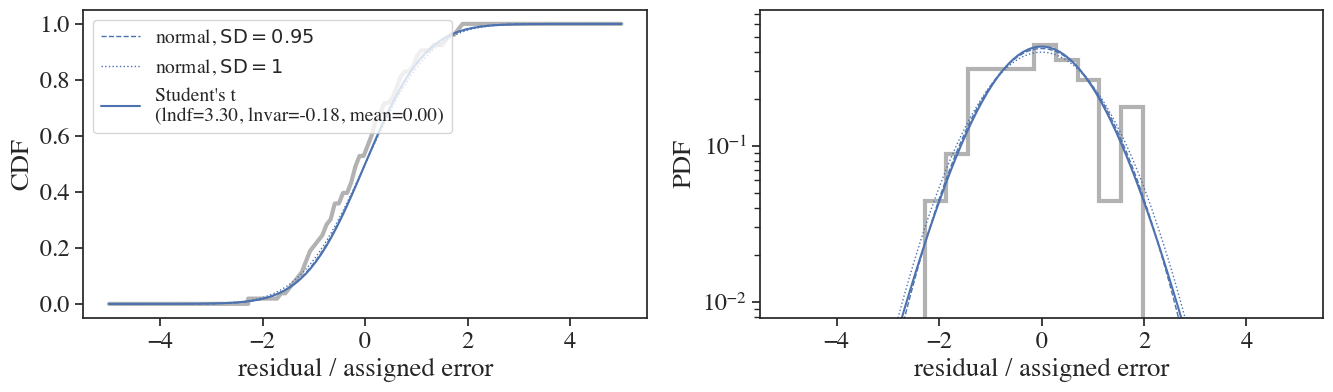

In [9]:
pdic_normal, pdic_student = jttv.check_residuals(popt)

### setup & run HMC

In [10]:
def model_scaled(sample_keys, param_bounds):
    """numpyro model for scaled parameters"""
    par = {}

    # sample parameters from priors
    for key in sample_keys:
        par[key+"_scaled"] = numpyro.sample(key+"_scaled", dist.Uniform(param_bounds[key][0]*0, param_bounds[key][0]*0+1.))
        par[key] = numpyro.deterministic(key, par[key+"_scaled"] * (param_bounds[key][1] - param_bounds[key][0]) + param_bounds[key][0])
    if "pmass" not in sample_keys:
        par["pmass"] = numpyro.deterministic("pmass", jnp.exp(par["lnpmass"]))
    
    # Jacobian for uniform ecc prior
    ecc = numpyro.deterministic("ecc", jnp.sqrt(par['ecosw']**2+par['esinw']**2))
    numpyro.factor("eprior", -jnp.log(ecc))

    # compute transit times
    tcmodel, ediff = jttv.get_transit_times_obs(par)
    numpyro.deterministic("ediff", ediff)
    numpyro.deterministic("tcmodel", tcmodel)
    
    # likelihood
    tcerrmodel = jttv.errorobs_flatten     
    numpyro.sample("obs", dist.Normal(loc=tcmodel, scale=tcerrmodel), obs=jttv.tcobs_flatten)

In [11]:
# physical parameters to sample from
sample_keys = ["ecosw", "esinw", "pmass", "period", "tic"] # uniform mass prior

In [12]:
pdic_scaled = scale_pdic(popt, param_bounds)

In [14]:
# information matrix and parameter covariance
from jnkepler.jaxttv.information import information
fisher_information = information(jttv, popt, sample_keys)
parameter_cov = jnp.linalg.inv(fisher_information)

In [17]:
for i,key in enumerate(sample_keys):
    print(key, np.diag(jnp.sqrt(parameter_cov))[3*i:3*i+3])

ecosw [0.00719355 0.01712575 0.01381532]
esinw [0.01789607 0.02762271 0.02291368]
pmass [4.66742109e-06 1.60937118e-06 3.22234204e-06]
period [0.00039617 0.00218359 0.00061378]
tic [0.00061482 0.00273945 0.00069872]


In [18]:
# Fisher information and parameter covariance matrix for scaled parameters
fisher_information_scaled = information(jttv, popt, sample_keys, param_bounds=param_bounds)
parameter_cov_scaled = jnp.linalg.inv(fisher_information_scaled)

computing scaled information matrix.


In [19]:
# initialize inverse mass matrix using parameter covariance
dense_mass = [tuple([key+"_scaled" for key in sample_keys])]
inverse_mass_matrix = {dense_mass[0]: parameter_cov_scaled}

In [20]:
kernel = NUTS(model_scaled, 
            init_strategy=init_to_value(values=pdic_scaled), 
            dense_mass=dense_mass,
            inverse_mass_matrix=inverse_mass_matrix,
            #regularize_mass_matrix=False # this speeds up sampling for unknown reason
            )

In [21]:
mcmc = MCMC(kernel, num_warmup=500, num_samples=1500, num_chains=num_chains)

In [22]:
rng_key = random.PRNGKey(0)
mcmc.run(rng_key, sample_keys, param_bounds, extra_fields=('potential_energy', 'num_steps', 'adapt_state'))

sample: 100%|██████████| 2000/2000 [3:56:20<00:00,  7.09s/it, 511 steps of size 7.28e-03. acc. prob=0.88]   


In [23]:
mcmc.print_summary()


                      mean       std    median      5.0%     95.0%     n_eff     r_hat
 ecosw_scaled[0]      0.47      0.02      0.47      0.44      0.50   1365.73      1.00
 ecosw_scaled[1]      0.53      0.03      0.52      0.48      0.57    534.78      1.01
 ecosw_scaled[2]      0.52      0.02      0.51      0.49      0.56    544.27      1.01
 esinw_scaled[0]      0.45      0.03      0.46      0.41      0.50    353.38      1.00
 esinw_scaled[1]      0.50      0.04      0.51      0.44      0.54    207.76      1.01
 esinw_scaled[2]      0.50      0.03      0.51      0.45      0.54    205.88      1.01
period_scaled[0]      0.50      0.00      0.50      0.50      0.50    979.04      1.01
period_scaled[1]      0.50      0.00      0.50      0.50      0.50    595.55      1.00
period_scaled[2]      0.50      0.00      0.50      0.50      0.50    516.15      1.00
 pmass_scaled[0]      0.01      0.01      0.01      0.00      0.02    434.46      1.00
 pmass_scaled[1]      0.01      0.00      

In [24]:
# save results
import dill
with open("kep51_ttv_iidnormal_inv-mass-matrix_mcmc.pkl", "wb") as f:
    dill.dump(mcmc, f)

### plot models drawn from posterior

In [25]:
samples = mcmc.get_samples()

In [26]:
means, stds = jttv.sample_means_and_stds(samples)

/Users/k_masuda/miniforge3/envs/jax4/lib/python3.10/site-packages/jnkepler-0.1.0-py3.10.egg/jnkepler/jaxttv/jaxttv.py:508: UserWarning: using t0 and P from a linear fit to the observed transit times.
  warnings.warn(


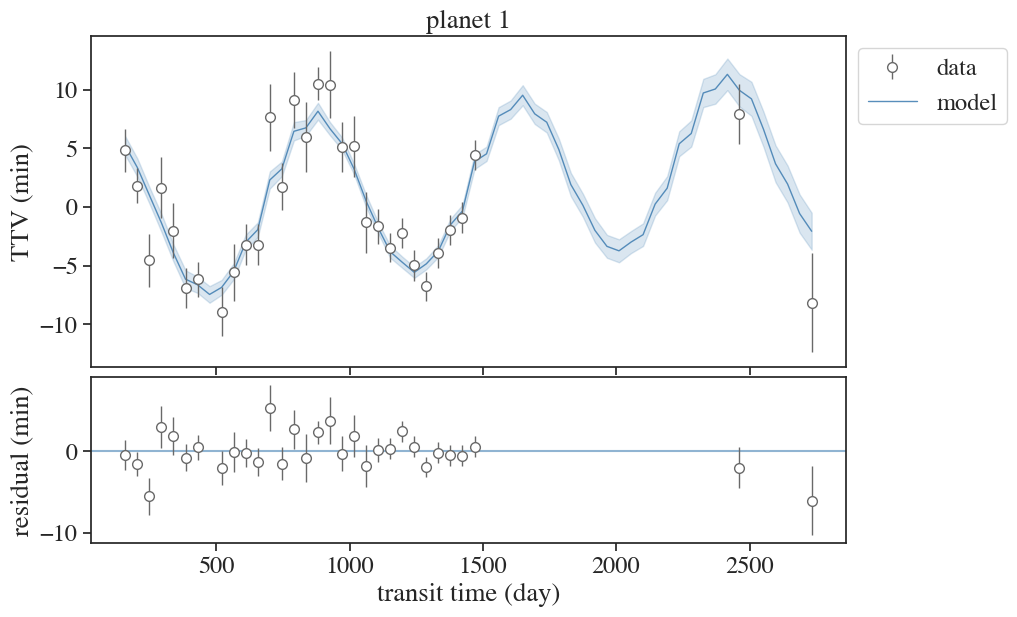

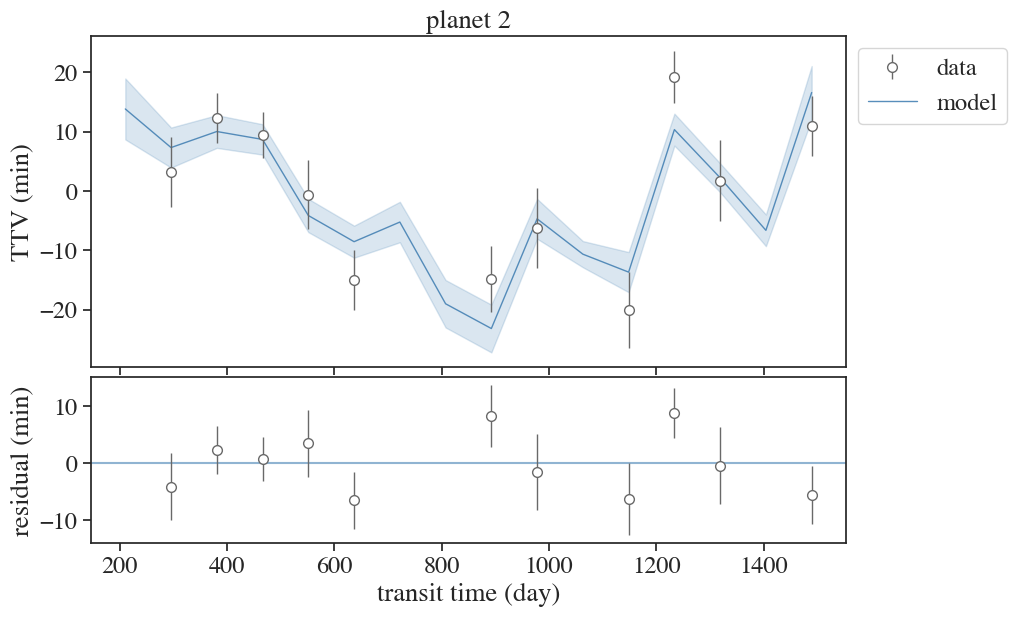

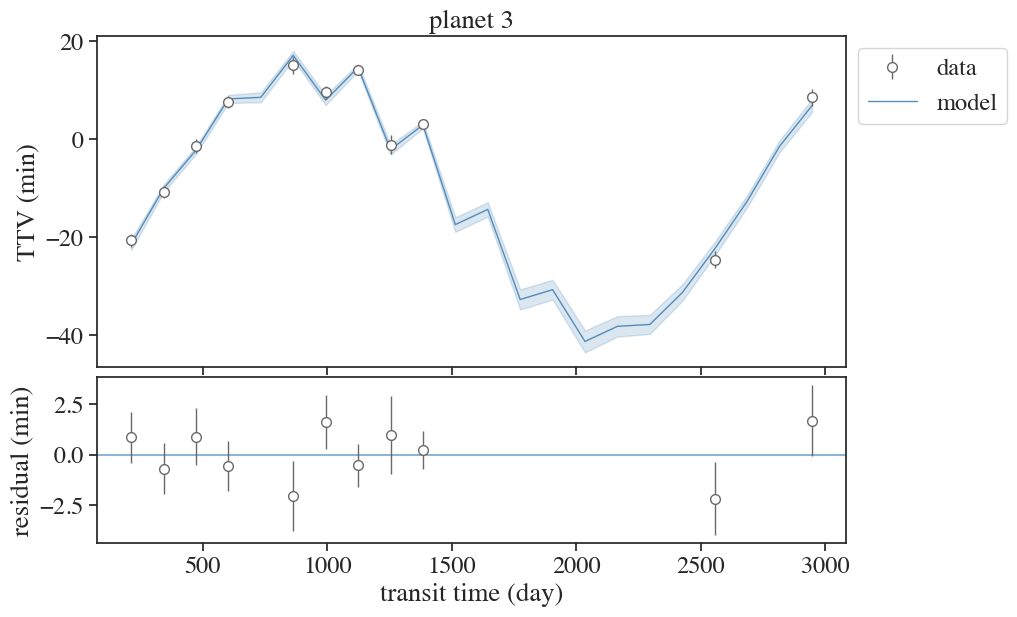

In [27]:
jttv.plot_model(means, tcmodelunclist=stds)

### comparison between parameter covariance vs posterior samples

The two agrees well except for eccentricity vectors; for which we incorporate 1/e weight for HMC to implement uniform ecc prior.

In [30]:
from scipy.stats import multivariate_normal
nsmp = len(samples['pmass'])
samples_arr = []
for i in range(nsmp):
    samples_arr.append(np.hstack([samples[key][i] for key in sample_keys]))
samples_arr = np.array(samples_arr)
mv = multivariate_normal(mean=np.mean(samples_arr, axis=0), cov=parameter_cov, allow_singular=True)

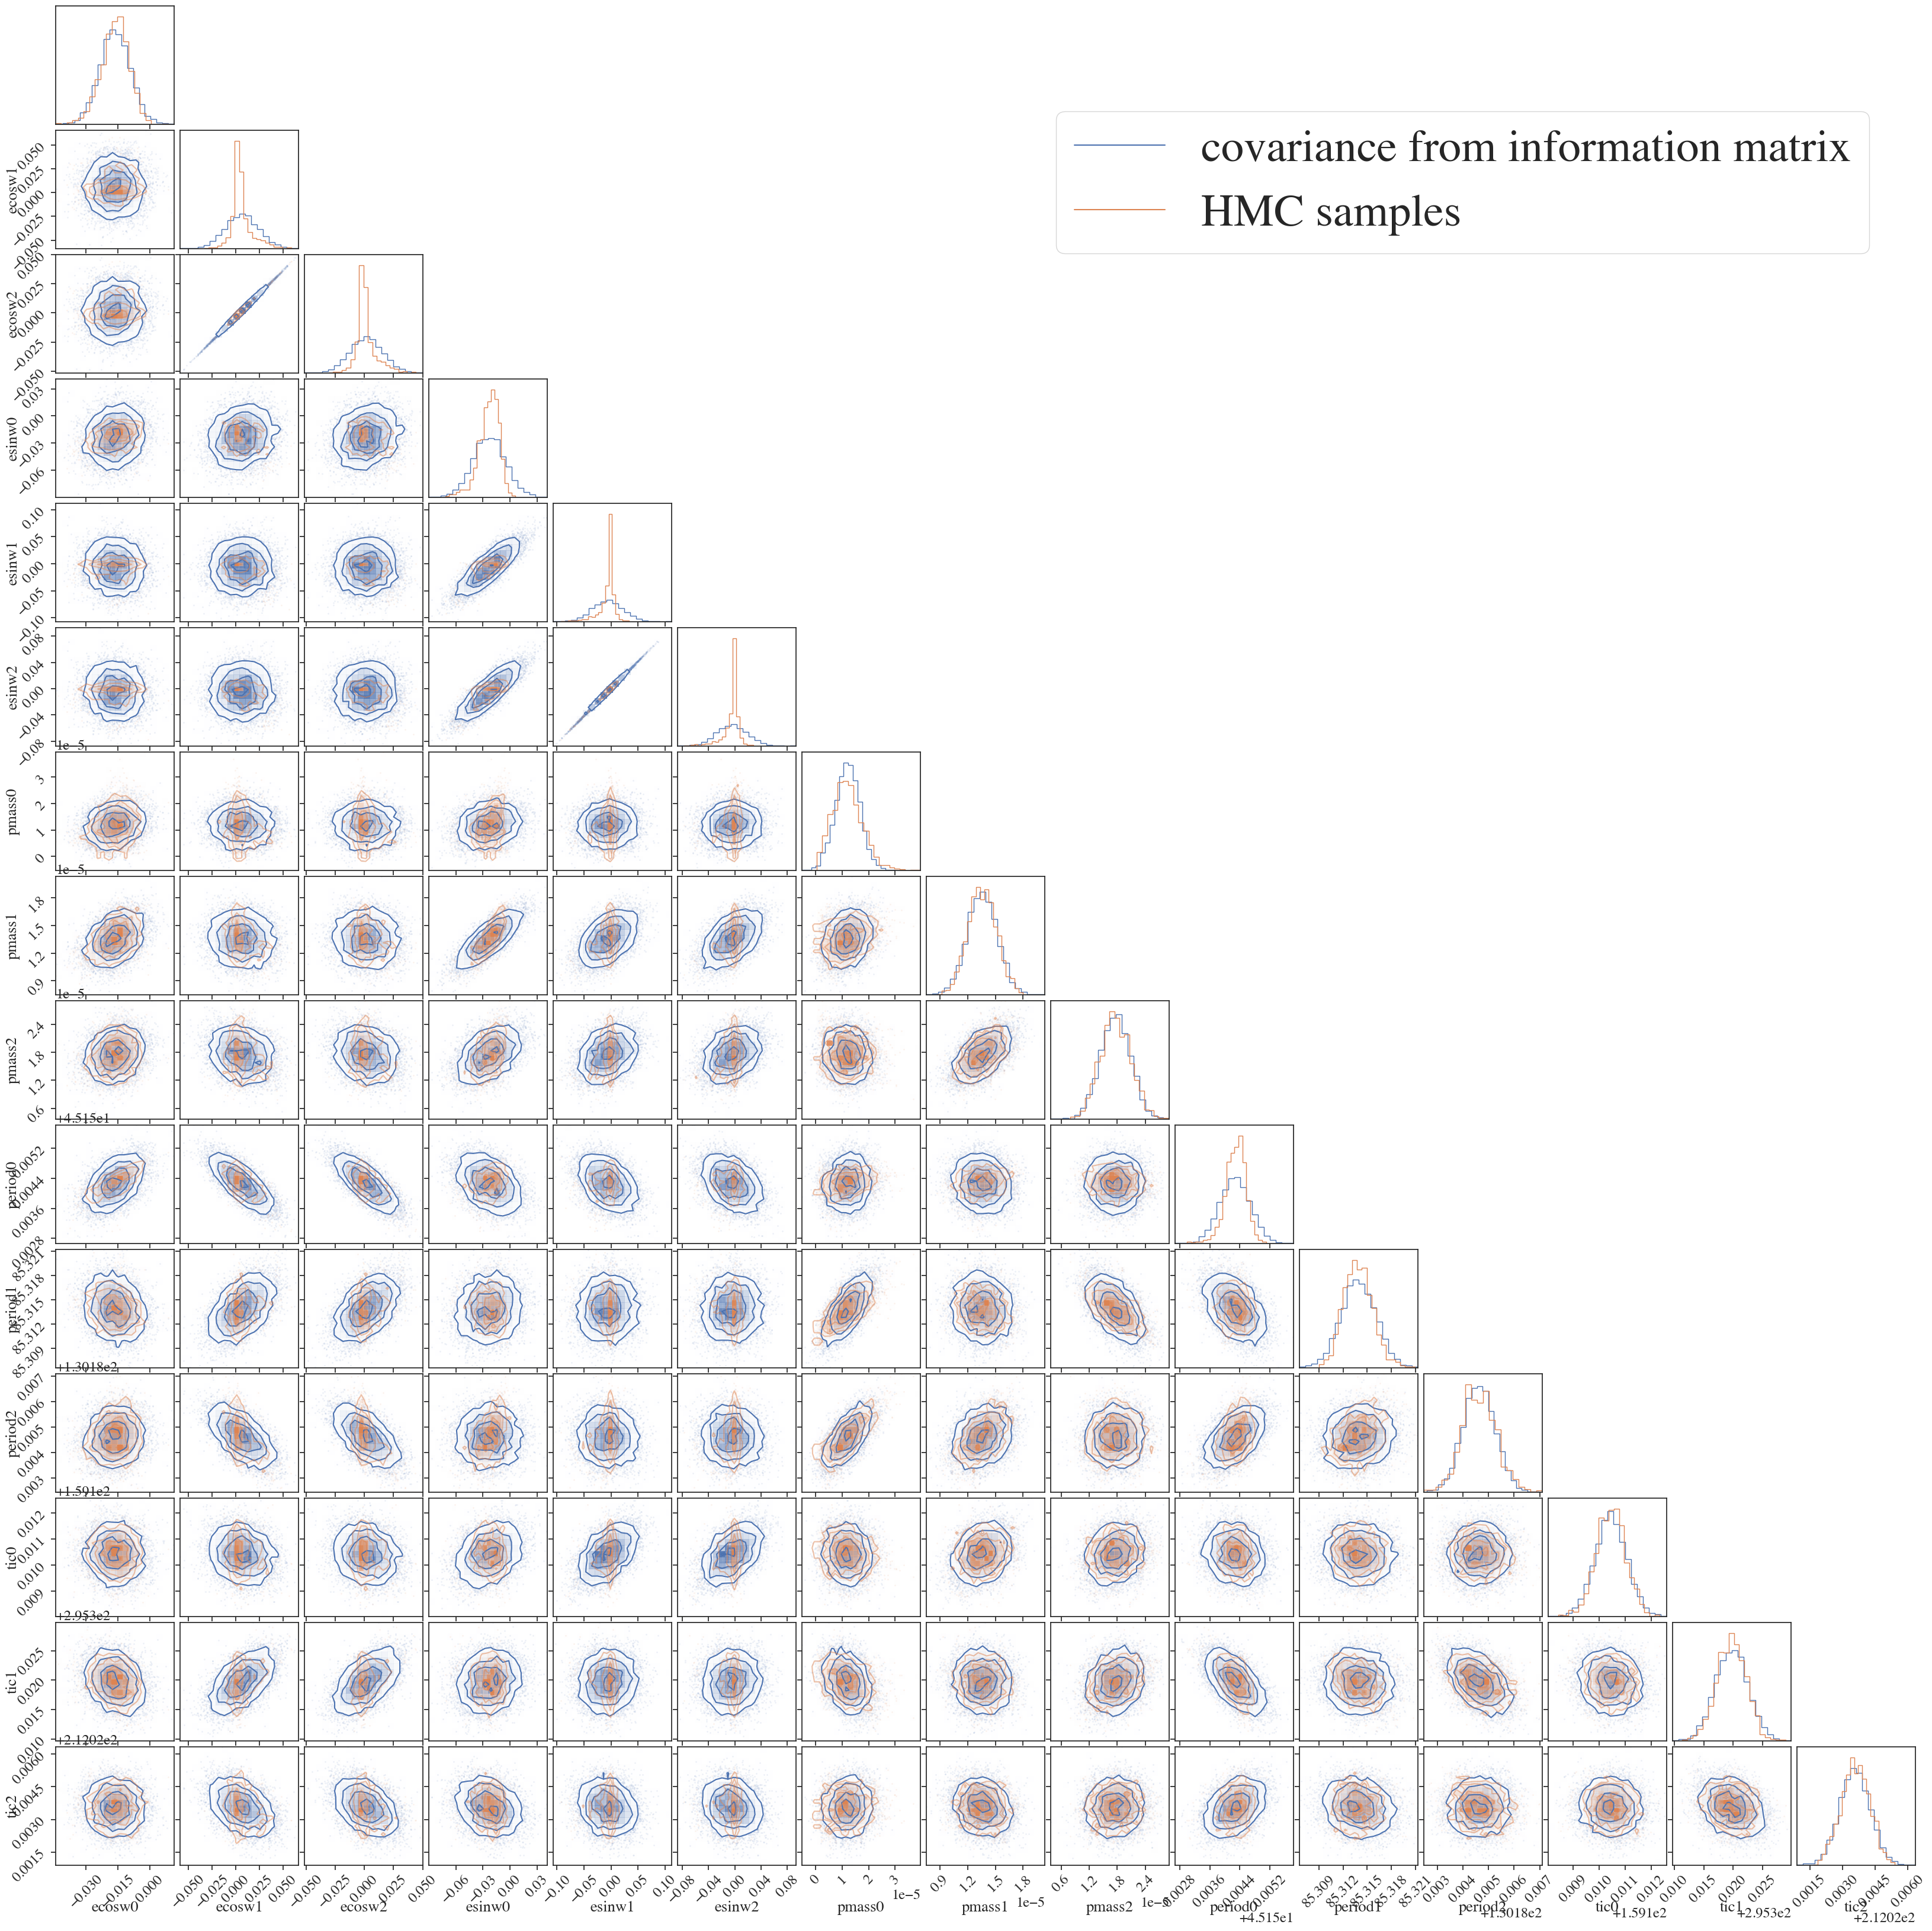

In [32]:
labels = []
for i,name in enumerate(sample_keys):
    for j in range(3):
        labels.append(name+"%d"%j)
labels = np.array(labels)

np.random.seed(123)
import matplotlib.lines as mlines
ndim = 15
names = ["covariance from information matrix", "HMC samples"]
fig_ = corner.corner(mv.rvs(size=6000), color='C0', hist_kwargs={'lw': 1., 'density': True})
fig = corner.corner(samples_arr, color='C1', fig=fig_, labels=labels, hist_kwargs={'lw': 1., 'density': True}, no_fill_contours=True, 
                    contourf_kwargs={'alpha': 0.5}, contour_kwargs={"alpha": 0.5})
handles = []
for i, name in enumerate(names):
    handles.append(mlines.Line2D([], [], color='C%d'%i, label=name))
plt.legend(handles=handles, bbox_to_anchor=(0.8, ndim), fontsize=55)

### trace and corner plots

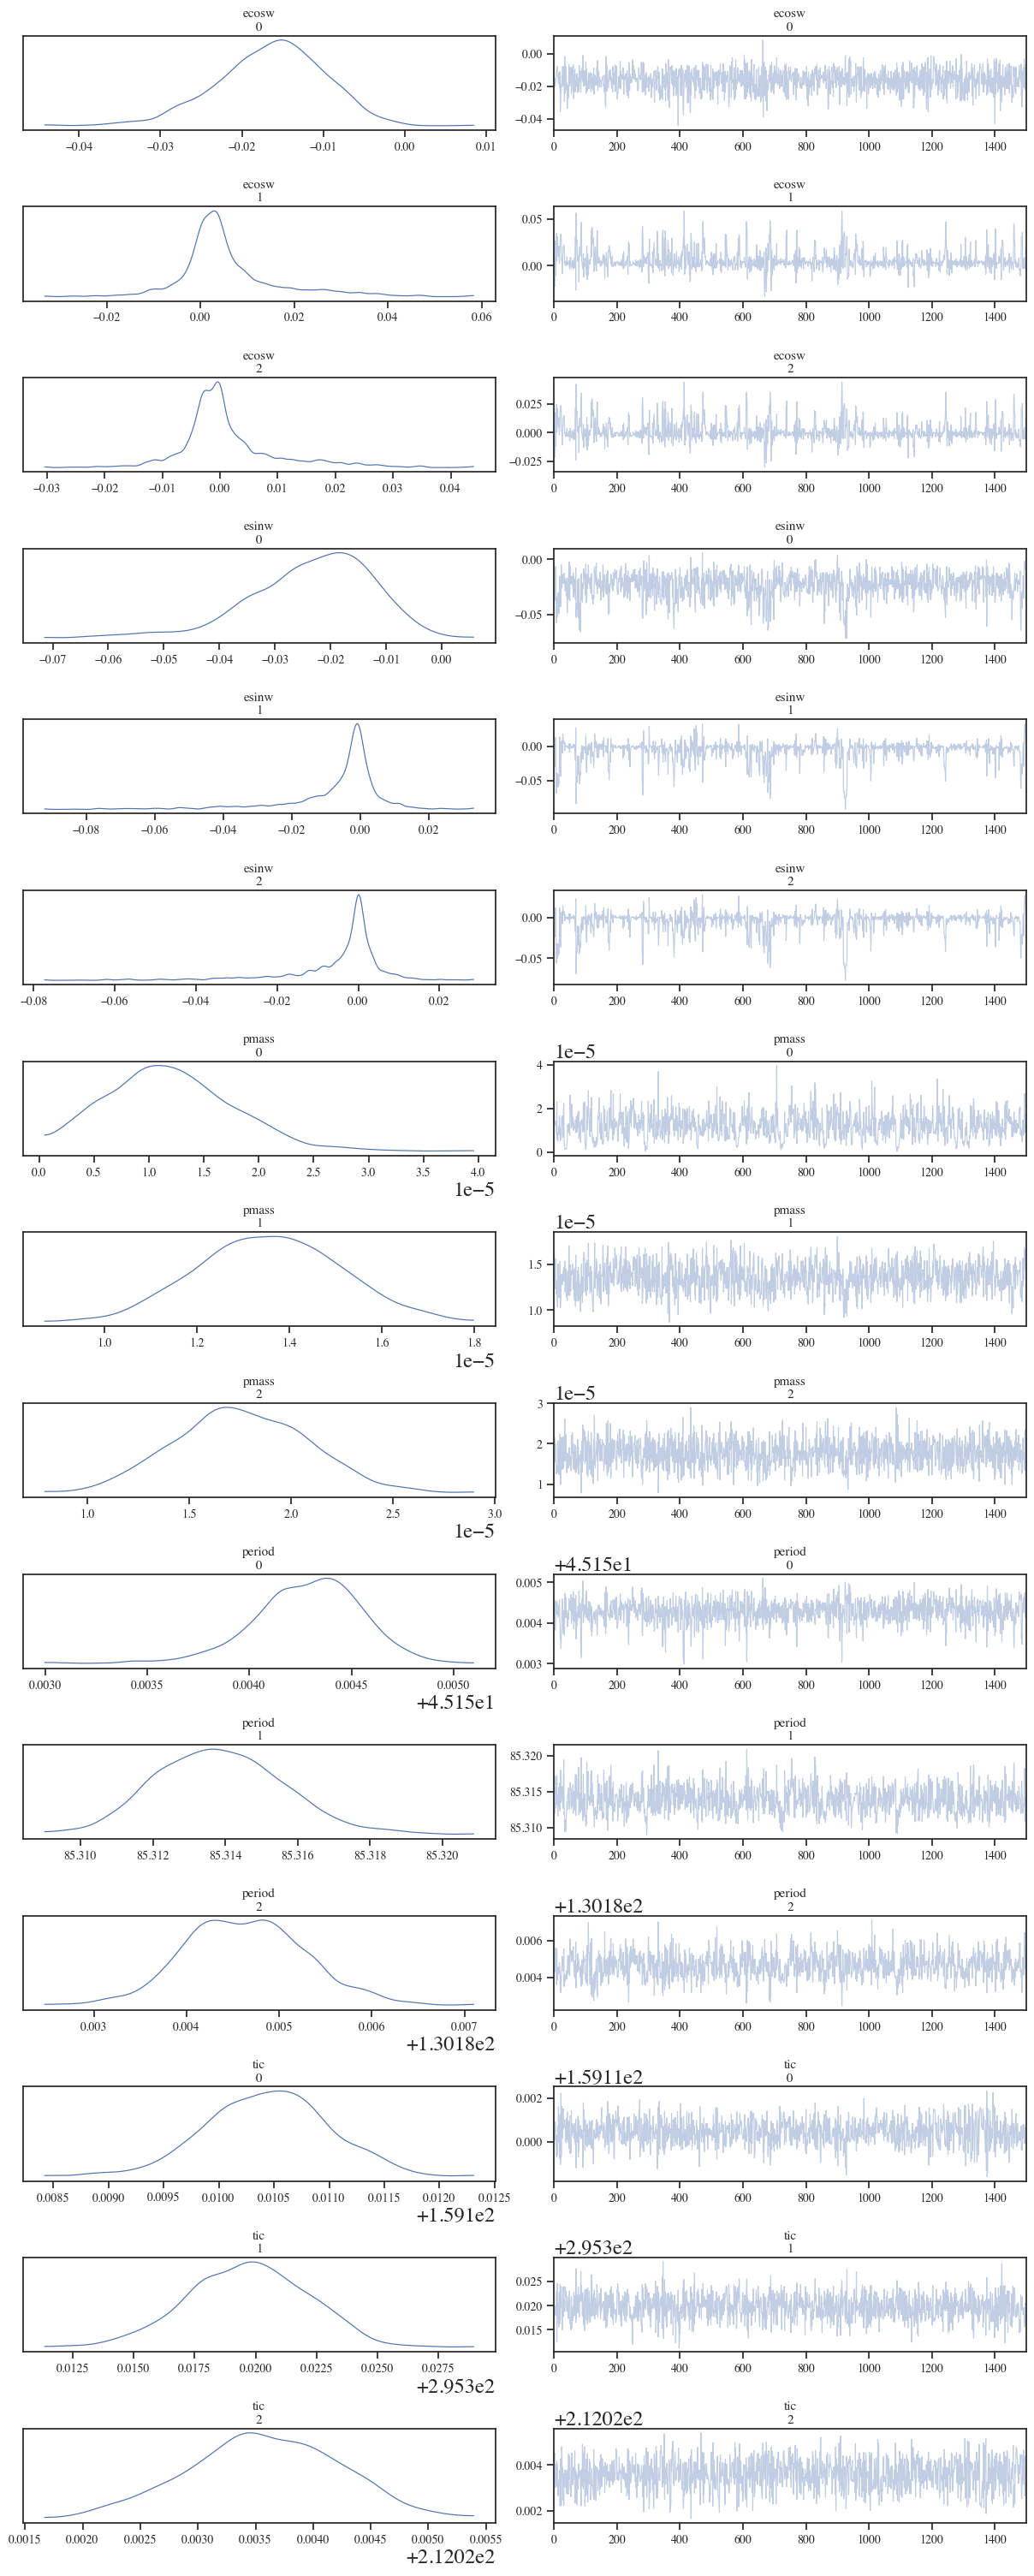

In [28]:
import arviz as az
idata = az.from_numpyro(mcmc)
fig = az.plot_trace(mcmc, var_names=sample_keys, compact=False)
plt.tight_layout(pad=0.2)

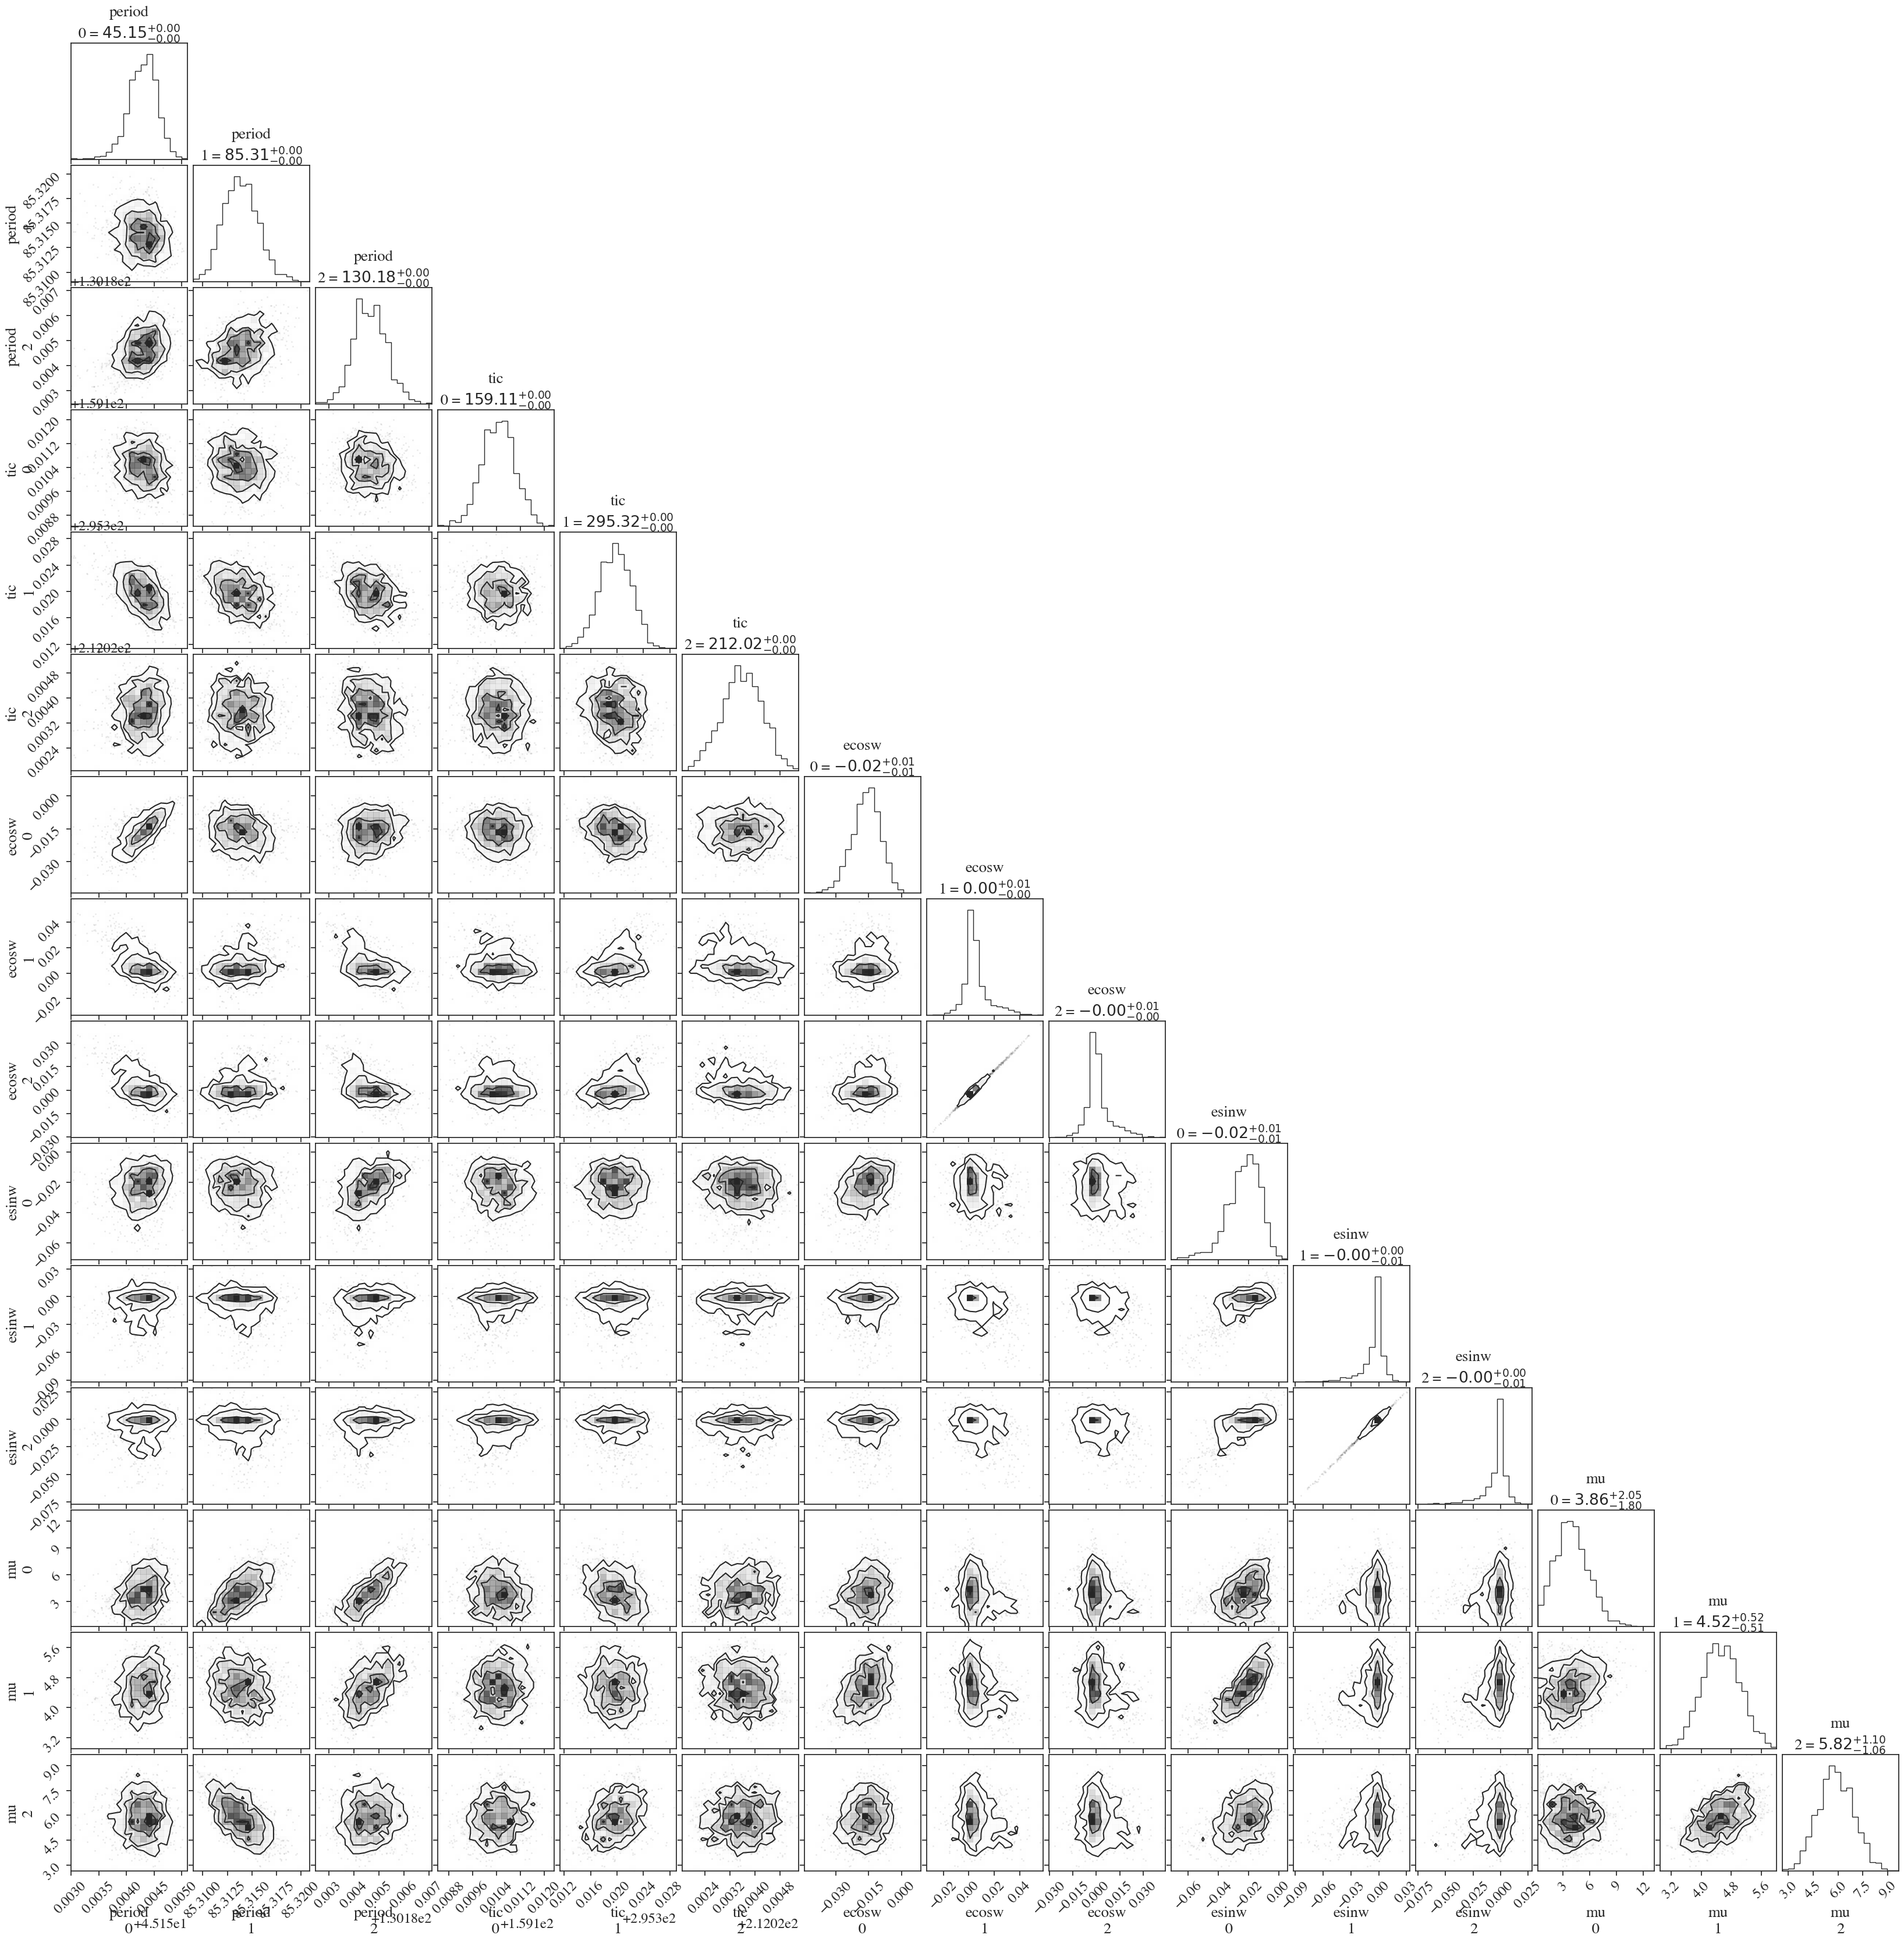

In [29]:
idata.posterior['mu'] = idata.posterior['pmass'] / 3.003e-6
names = ["period", "tic", "ecosw", "esinw", "mu"]
fig = corner.corner(idata, var_names=names, show_titles=True)